In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kevinlu/anaconda

In [2]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [3]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())

In [4]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [5]:
# use coef_ instead of feature_importance_
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    importance = [x for x in model.coef_[0]]
    feat_imp = pd.Series(importance,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Coef')
    plt.title('Feature Coef', size = 20);

In [6]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
    feature_chart = feature_importance(model)
    
    return output

# Baseline

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default,1878,9,0.920844,0.920354,0.059082,0.052472,0.947389,0.946968


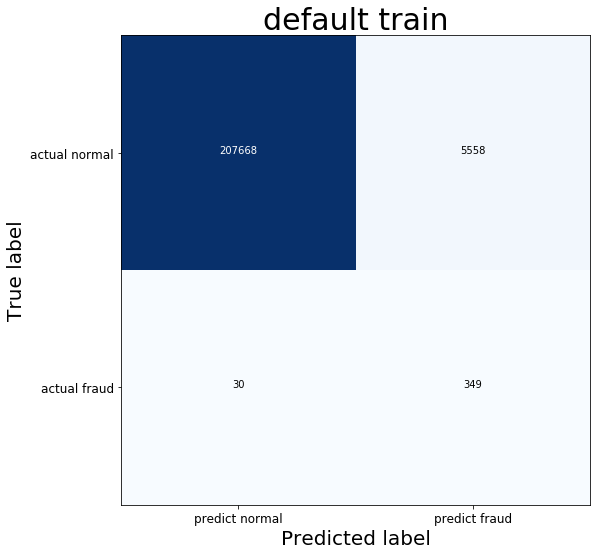

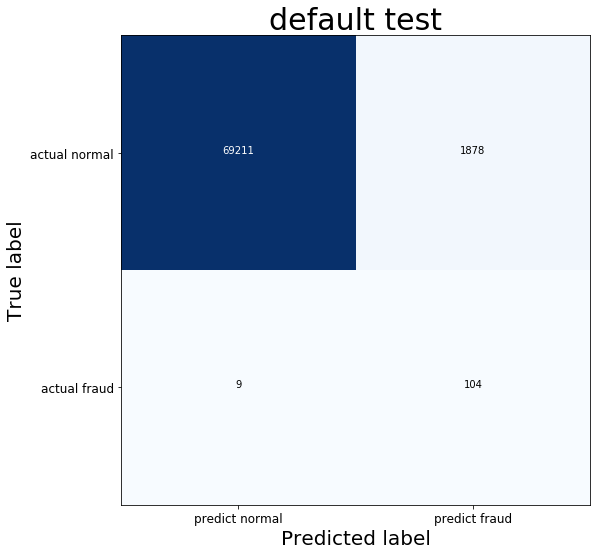

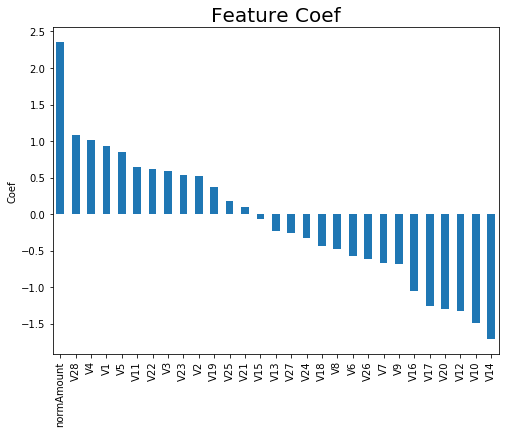

In [7]:
log_reg = LogisticRegression(random_state=42)
model = log_reg.fit(X_train_sm, y_train_sm.ravel())
model_vis(model,'default')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default stratify,1736,9,0.92876,0.920354,0.062445,0.056522,0.951987,0.947967


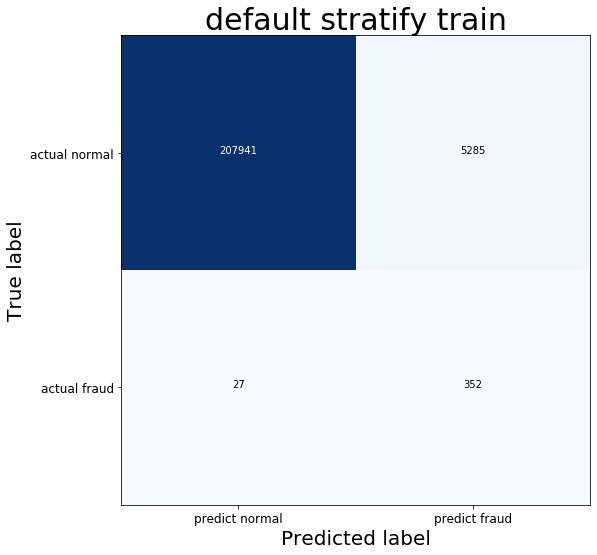

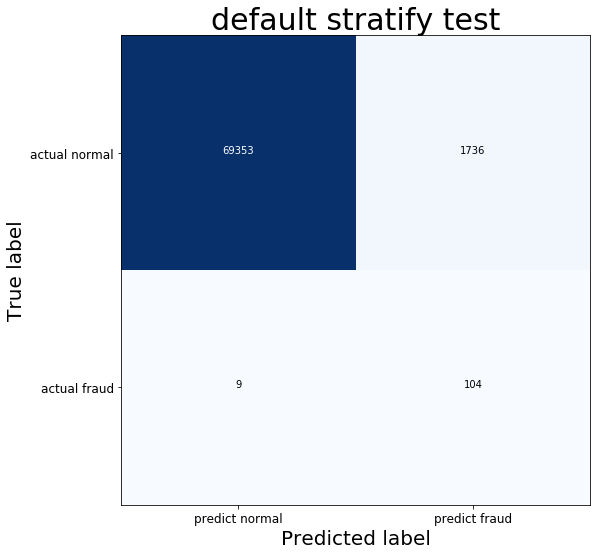

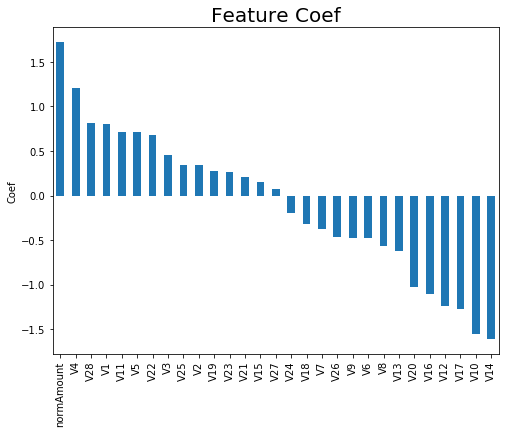

In [8]:
log_reg = LogisticRegression(random_state=42)
model = log_reg.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'default stratify')

# Param tuning

In [ ]:
# penalty: l1,l2,elasticnet
# C: smaller, stronger regulation
# solver: newton-cg, lbfgs, sag, saga (l2); liblinear, saga (l1); saga(elasticnet)
# l1_ration: only elasticnet

In [9]:
param_grid = {
    'penalty':['l1','l2','elasticnet','none'],
    'C': [10, 1, 0.1]
}

gs1 = GridSearchCV(LogisticRegression(random_state=42), 
                   param_grid=param_grid, 
                   cv = 5, 
                   verbose= 3, 
                   n_jobs=4)


gs1.fit(X_train_sm_sf,y_train_sm_sf.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.3min finished
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [10, 1, 0.1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [10]:
gs1.best_params_, gs1.best_score_

({'C': 10, 'penalty': 'none'}, 0.9546277350012053)

## Step 2

In [11]:
param_grid = {
    'C': [100,50,10],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

gs2 = GridSearchCV(LogisticRegression(penalty='none',
                                      random_state=42), 
                   param_grid=param_grid, 
                   cv = 5, 
                   verbose= 3, 
                   n_jobs=4)


gs2.fit(X_train_sm_sf,y_train_sm_sf.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  9.0min finished
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [100, 50, 10],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [12]:
gs2.best_params_, gs2.best_score_

({'C': 100, 'solver': 'lbfgs'}, 0.9546277350012053)

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 1,1735,9,0.92876,0.920354,0.062456,0.056552,0.951989,0.947974


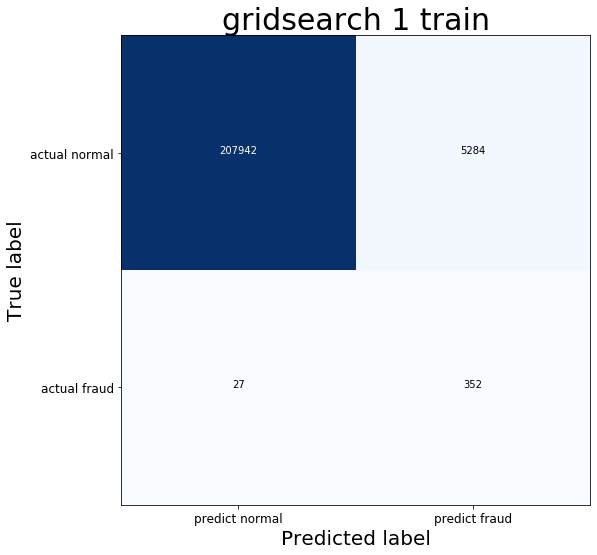

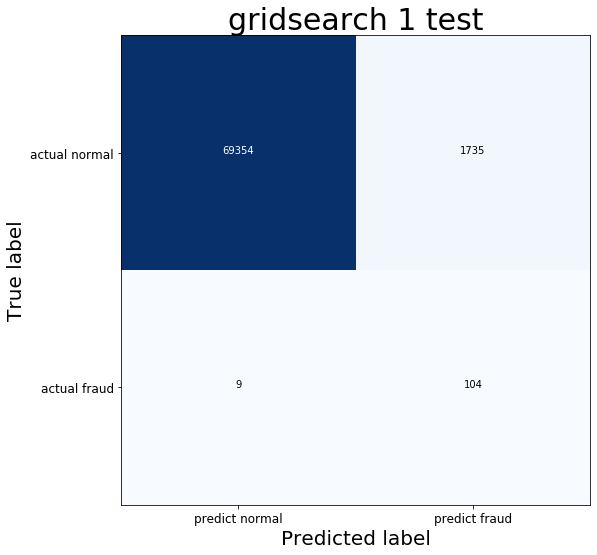

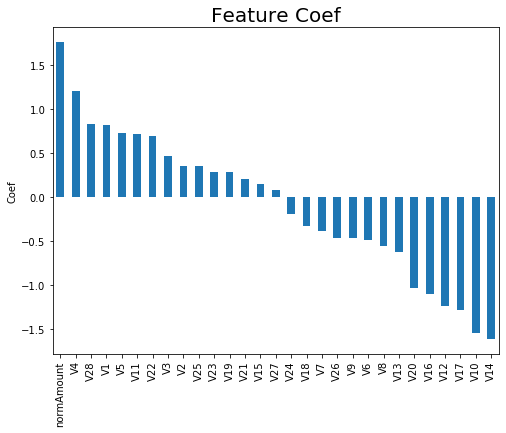

In [14]:
log_param = LogisticRegression(C = 10, random_state=42)
model = log_param.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'gridsearch 1')